## API: OpenAQ API
https://docs.openaq.org/


1. Locations Query: "https://api.openaq.org/v3/locations"
2. Pollutant Information: "https://api.openaq.org/v3/parameters"
3. Monthly Average: "https://api.openaq.org/v3/sensors/{sensor_id}/days/monthly"

It then uses this data to answer 2 analytic questions:

1. Which Grand Slam tournament location (US, French, Australian, Wimbledon) tends to experience the best and worst air quality overall?

2. Does court type affect it?

All data is loaded directly into DataFrames.

# **Step 1: Set up**

In [1]:
from datetime import datetime
print(f'Run time: {datetime.now().strftime("%D %T")}')

Run time: 01/31/26 18:02:13


In [2]:

! pip install openaq

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import requests
import pprint
from openaq import OpenAQ
import pandas as pd
import time
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from openaq.shared.responses import Measurement

C:\Users\natex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\openaq\__init__.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [4]:
#ENDPOINTS
locations = "https://api.openaq.org/v3/locations"
parameters = "https://api.openaq.org/v3/parameters"
measurement = "https://api.openaq.org/v3/sensors/{sensors_id}/hours/daily"

In [5]:
#Define API key
API_KEY = os.getenv("OPENAQ_API_KEY")

# **Step 2: Create list of dictionaries for events**



In [6]:
#NOTE: Sensors for Australian Open had a substantial amoount of misssing or incomplete data,
#to circumnagivate this, data for the Austrlian Openwas fetched from 2023 as opposed to 2025
#like the other events.
tennis_arenas = [
    {"event": "Australian Open",
    "coordinates":"-37.821465, 144.978317",
    "radius":14000,
    "window_start":"2023-01-13T00:00:00Z",  # 3 days before
    "window_end":"2023-02-01T23:59:59Z",  # 3 days after
    "event_start":"2023-01-16T00:00:00Z",  # official start
    "event_end":"2023-01-29T23:59:59Z",   # official end
    "court_type":"hard"
    },
    {"event":"French Open",
     "coordinates":"48.8468689, 2.2484181",
     "radius":14000,
     "window_start":"2025-05-21T00:00:00Z", # 3 days before
     "window_end":"2025-06-10T23:59:59Z", # 3 days after
     "event_start":"2025-05-24T00:00:00Z", # official start
     "event_end":"2025-06-07T23:59:59Z", # official end
     "court_type":"clay"
     },
    {"event":"Wimbledon",
     "coordinates":"51.433727, -0.214443",
     "radius":14000,
     "window_start":"2025-06-26T00:00:00Z", # 3 days before
     "window_end":"2025-07-15T23:59:59Z", # 3 days after
     "event_start":"2025-06-29T00:00:00Z", # official start
     "event_end":"2025-07-12T23:59:59Z", # official end
     "court_type":"grass"
     },
    {"event":"US Open",
     "coordinates":"40.750694, -73.846336",
     "radius":14000,
     "window_start":"2025-08-22T00:00:00Z", # 3 days before
     "window_end":"2025-09-10T23:59:59Z", # 3 days after
     "event_start":"2025-08-25T00:00:00Z", # official start
     "event_end":"2025-09-07T23:59:59Z", # official end
     "court_type":"hard"
     }
]

# **Step 3: Define functions to fetch and aggregate data**

In [7]:
def harvest(url, name, coord, rad):
    """
    Retrieve nearby sensor information from the OpenAQ API and organize results.

    Parameters:
        url : str
            The API endpoint for querying OpenAQ locations.
        name : str
            A label used as the dictionary key grouping returned sensor data
            (e.g., the event name or location category).
        coord : str
            The latitude/longitude of the query center in "lat,lon" format.
        rad : int or float
            Search radius in meters for nearby sensors (1,000 = 1km).

    Returns:
        tuple
            location_ids : list
                A list of unique location IDs found near the coordinates.
            parameter_ids : list
                A list of unique pollutant parameter IDs present in the returned data.
            harvest : dict
                A dictionary keyed by `name` containing a list of sensor metadata records.
    """

    headers = {"x-api-key": API_KEY}
    params = {"coordinates": coord, "radius": rad, "limit": 100}

    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    results = data.get("results", [])

    harvest = {name: []}
    location_ids = []
    parameter_ids = []

    for result in results:
        locality = result.get("locality")
        city = result.get("name")

        provider = result.get("provider", {})
        provider_name = provider.get("name")
        provider_id = provider.get("id")

        sensors = result.get("sensors", [])

        for sensor in sensors:
            sensor_id = sensor.get("id")
            pollutant = sensor.get("name")
            p_id = sensor.get("parameter", {}).get("id")

            if p_id and p_id not in parameter_ids:
                parameter_ids.append(p_id)

            sensor_summary = {
                "Sensor ID": sensor_id,
                "Pollutant": pollutant,
                "Pollutant ID": p_id,
                "Locality": locality,
                "City": city,
                "Provider Name": provider_name,
                "Provider ID": provider_id
            }
            harvest[name].append(sensor_summary)

    return parameter_ids, harvest

In [8]:
def get_measurement(sensor_id, start_date, end_date, retries=5, timeout=20):
    """
    Retrieve daily aggregated air quality measurements for a given sensor
    from the OpenAQ API, with built-in timeout, retry logic, and exponential
    backoff to prevent stalled requests and client timeouts.

    Parameters
    ----------
    sensor_id : str or int
        The OpenAQ sensor ID from which to retrieve measurements.
    start_date : str
        Start of the desired date range (UTC ISO string, e.g. "2024-09-01T00:00:00Z").
    end_date : str
        End of the desired date range (UTC ISO string).
    retries : int, optional
        Number of times to retry the request if it times out or the API returns
        a rate-limit or server error. Default is 5.
    timeout : int or float, optional
        Maximum number of seconds to wait for a server response before treating
        the request as timed out. Default is 20 seconds.

    Returns
    -------
    list
        A list of daily measurement records returned by the OpenAQ API.
        Each record may include:
            - period.datetimeFrom.utc : str
            - period.datetimeTo.utc   : str
            - value                   : float
            - units, pollutant, sensor metadata, etc.

        Returns an empty list if:
            - the sensor has no results in the given date range,
            - the API request fails after all retries,
            - a non-recoverable client error occurs (400-499 except 429).
    """

    url = f"https://api.openaq.org/v3/sensors/{sensor_id}/days"
    headers = {"X-API-Key": API_KEY}
    params = {
        'date_from': start_date,
        'date_to': end_date
    }

    for attempt in range(retries):
        try:
            response = requests.get(
                url,
                headers=headers,
                params=params,
                timeout=timeout  # Prevents hanging requests
            )

            # Successful request
            if response.status_code == 200:
                return response.json().get("results", [])

            # Rate limit reached
            if response.status_code == 429:
                wait = 5 * (attempt + 1)
                print(f"Rate limit hit. Waiting {wait}s…")
                time.sleep(wait)
                continue

            # Server (5xx) error, retry
            if response.status_code >= 500:
                wait = 3 * (attempt + 1)
                print(f"Server error {response.status_code}. Retrying in {wait}s…")
                time.sleep(wait)
                continue

            # Other client errors (400, 404, etc.)
            print(f"Error {response.status_code}: {response.text}")
            return []

        except requests.exceptions.Timeout:
            wait = 3 * (attempt + 1)
            print(f"Timeout. Retrying in {wait}s…")
            time.sleep(wait)

        except requests.exceptions.RequestException as e:
            print("Request failed:", str(e))
            time.sleep(2)

    print("Max retries reached. Returning empty list.")
    return []

In [9]:
def union_ids(event_dict):
    """
    Compute the intersection of pollutant IDs across multiple event locations
    and return their associated event data.

    Parameters:
        event_dict : list[dict]

        A list of event dictionaries, where each dictionary must contain:
        - "event": str, the event or source name
        - "coordinates": tuple(float, float), latitude/longitude pair
        - "radius": float, search radius for the query

    Returns:
        A list of event data objects returned from `harvest` for each event filtered
        to only show pollutants measured in all locations of set.
    """

    results = []
    master_ids = []

    # First pass to gather IDs
    for x in event_dict:
        pollutant_ids, event_data = harvest(locations, x["event"], x["coordinates"], x["radius"])
        master_ids.append(set(pollutant_ids))
        results.append(event_data)

    # Find common IDs
    union_ids = set.union(*master_ids)
    print("All Pollutant IDs :", union_ids) #remove this eventually

    # Second pass to filter
    filtered_results = []
    for event_data in results:
        event_name, rows = next(iter(event_data.items()))
        filtered_rows = [r for r in rows if r["Pollutant ID"] in union_ids]
        filtered_results.append({event_name: filtered_rows})

    return filtered_results

In [10]:
def day_labels_convert2df(event_list, filtered_results, delay=0.5):
    """
    Build a daily dataframe for each (event, sensor_id, pollutant),
    and add a relative day index aligned to the official event start, with readable labels.

    Parameters
    ----------
    event_list : list[dict]
        Each dict requires keys: "event", "window_start", "window_end", "event_start", "event_end".
    filtered_results : list[dict]
        Sequence of mappings {event_name: [ { "Sensor ID": ..., "Pollutant": ... }, ... ] }
    delay : float
        Delay between API calls to avoid rate limits.

    Returns
    -------
    pd.DataFrame
        Columns:
            datetime_from (UTC, daily)
            event
            sensor_id
            pollutant
            pollutant_id
            value
            day_relative
            day_label
            month_day_year
    """

    rows = []

    # Build event lookup
    event_lookup = {}
    for e in event_list:
        window_start = pd.to_datetime(e["window_start"], utc=True).normalize()
        window_end = pd.to_datetime(e["window_end"], utc=True).normalize()
        official_start = pd.to_datetime(e["event_start"], utc=True).normalize()
        official_end = pd.to_datetime(e["event_end"], utc=True).normalize()

        event_lookup[e["event"]] = {
            "window_start": window_start,
            "window_end": window_end,
            "event_start": official_start,
            "event_end": official_end
        }

    # Harvest measurements
    for group in filtered_results:
        for event_name, sensors in group.items():
            if event_name not in event_lookup:
                raise KeyError(f"Event '{event_name}' missing in event list")

            for sensor in sensors:
                sid = sensor["Sensor ID"]
                pol = sensor["Pollutant"]

                results = get_measurement(
                    sid,
                    event_lookup[event_name]["window_start"],
                    event_lookup[event_name]["window_end"]
                )
                time.sleep(delay)

                if not results:
                    rows.append({
                        "datetime_from": pd.NaT,
                        "event": event_name,
                        "sensor_id": sid,
                        "pollutant": pol,
                        "pollutant_id": None,
                        "value": np.nan
                    })
                    continue

                for r in results:
                    dt_from = r.get("period", {}).get("datetimeFrom", {}).get("utc")
                    pid = r.get("parameter", {}).get("id", None)
                    val = r.get("value")

                    rows.append({
                        "datetime_from": dt_from,
                        "event": event_name,
                        "sensor_id": sid,
                        "pollutant": pol,
                        "pollutant_id": pid,
                        "value": val
                    })

    # Build raw DataFrame
    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df["datetime_from"] = pd.to_datetime(df["datetime_from"], errors="coerce", utc=True)
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["datetime_from"])

    # Aggregate daily
    df["date"] = df["datetime_from"].dt.normalize()
    agg_cols = ["event", "sensor_id", "pollutant"]

    daily = (
        df.groupby(agg_cols + ["date"], as_index=False)
          .agg({
              "value": "mean",
              "pollutant_id": lambda x: pd.Series(x).dropna().iloc[0] if pd.Series(x).dropna().size > 0 else None
          })
    )

    # Add relative day indices
    event_start_lookup = {e["event"]: pd.to_datetime(e["event_start"], utc=True).normalize() for e in event_list}
    event_end_lookup = {e["event"]: pd.to_datetime(e["event_end"], utc=True).normalize() for e in event_list}

    daily["day_relative_start"] = (daily["date"] - daily["event"].map(event_start_lookup)).dt.days
    daily["day_relative_end"] = (daily["date"] - daily["event"].map(event_end_lookup)).dt.days

    # Build readable day labels
    def make_day_label(row):
        start = event_start_lookup[row["event"]]
        end = event_end_lookup[row["event"]]
        if row["date"] < start:
            return f"Day {row['day_relative_start']}"  # negative days
        elif row["date"] > end:
            return f"Day +{row['day_relative_end']}"   # after event end
        else:
            return f"Day {row['day_relative_start']}"

    daily["day_label"] = daily.apply(make_day_label, axis=1)
    daily["month_day_year"] = daily["date"].dt.strftime("%B %d %Y")

    # Final column order
    daily = daily[[
        "date", "event", "sensor_id", "pollutant",
        "pollutant_id", "value", "day_relative_start", "day_label", "month_day_year"
    ]].rename(columns={"date": "datetime_from", "day_relative_start": "day_relative"})

    daily = daily.sort_values(["event", "sensor_id", "pollutant", "datetime_from"]).reset_index(drop=True)

    return daily

# **Step 4: Call functions and create visualizations**

In [11]:
#Nathan
tennis_ids = union_ids(tennis_arenas)
tennis_df = day_labels_convert2df(tennis_arenas,tennis_ids)
tennis_df.sample(5)

All Pollutant IDs : {1, 2, 3, 19843, 5, 4, 7, 8, 9, 10, 6, 19, 21, 27, 98, 35, 100, 125}


,datetime_from,event,sensor_id,pollutant,pollutant_id,value,day_relative,day_label,month_day_year
1828,2025-08-26 00:00:00+00:00,US Open,9648782,pm1 µg/m³,19.0,2.68,1,Day 1,August 26 2025
2169,2025-08-27 00:00:00+00:00,US Open,12212729,temperature c,100.0,21.90,2,Day 2,August 27 2025
1229,2025-06-03 00:00:00+00:00,French Open,4661655,pm25 µg/m³,2.0,5.80,10,Day 10,June 03 2025
2439,2025-07-10 00:00:00+00:00,Wimbledon,238,no2 µg/m³,5.0,26.90,11,Day 11,July 10 2025
1633,2025-08-30 00:00:00+00:00,US Open,1146,pm25 µg/m³,2.0,4.16,5,Day 5,August 30 2025


In [12]:
# Convert o3 volume into mass
mask = tennis_df["pollutant"] == "o3 ppm"

# Convert values
tennis_df.loc[mask, "value"] = tennis_df.loc[mask, "value"] * 1960

# Fix the unit in pollutants column
tennis_df.loc[mask, "pollutant"] = "o3 µg/m³"

In [13]:
# --- Aggregate average tournament data ---
average = (
    tennis_df
    .groupby(["pollutant", "event"])["value"]
    .mean()
    .reset_index()
)

# Window averages (sorted by value)
pm25_window_average = (
    average.query("pollutant == 'pm25 µg/m³'")
    .sort_values("value", ascending=True)
)

o3_window_average = (
    average.query("pollutant == 'o3 µg/m³'")
    .sort_values("value", ascending=True)
)

# --- Aggregate average daily data ---
daily_average = (
    tennis_df
    .groupby(["pollutant", "event", "day_relative", "day_label"])["value"]
    .mean()
    .reset_index()
)

# Preserve event order from window averages
event_order_pm25 = pm25_window_average["event"].tolist()
event_order_o3   = o3_window_average["event"].tolist()

# Daily averages (sorted by event order + day_relative)
pm25_daily_average = (
    daily_average.query("pollutant == 'pm25 µg/m³'")
    .set_index("event")
    .loc[event_order_pm25]   # enforce consistent event order
    .reset_index()
    .sort_values("day_relative")
)

o3_daily_average = (
    daily_average.query("pollutant == 'o3 µg/m³'")
    .set_index("event")
    .loc[event_order_o3]
    .reset_index()
    .sort_values("day_relative")
)

hue_order = o3_window_average["event"].tolist()

# *Visualizations*

# **1. Which Grand Slam tournament location (US, French, Australian, Wimbledon) tends to experience the best and worst air quality overall?**


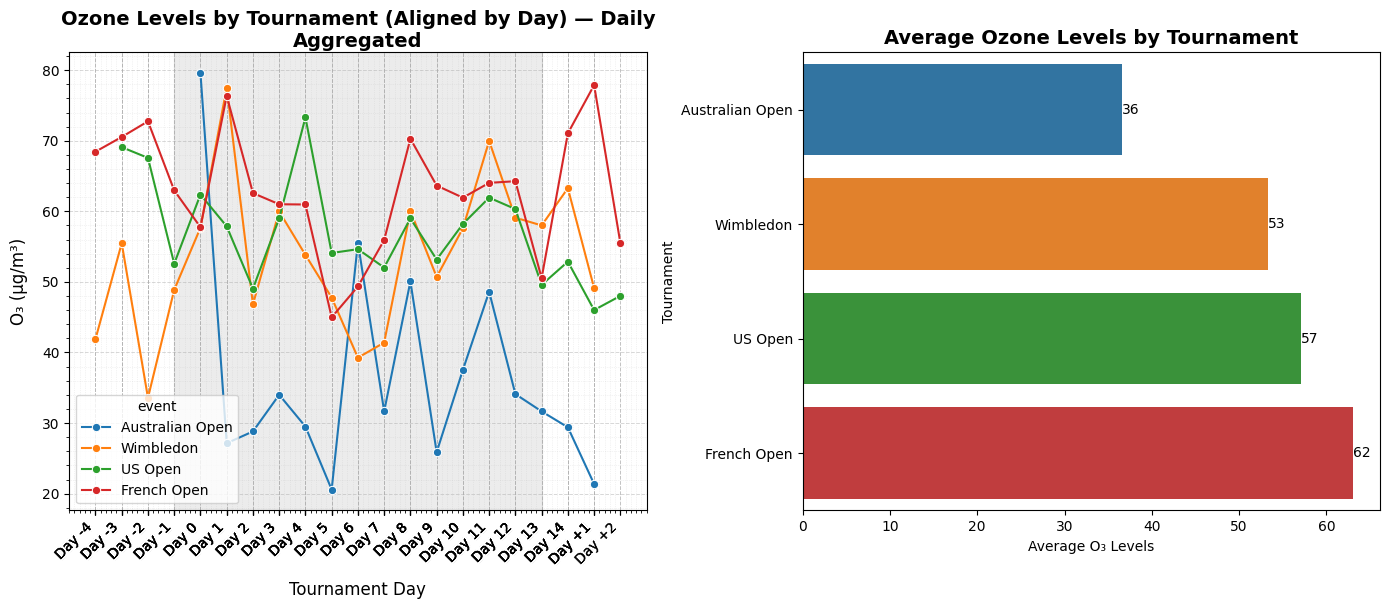

In [14]:
# Create composite plots for O₃
# First subplot Line Chart
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

ax1 = sns.lineplot(
    data=o3_daily_average,
    x="day_relative",
    y="value",
    hue="event",
    hue_order=hue_order,
    marker="o"
)

# Add titles, labels, and grid
ax1.minorticks_on()
ax1.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.5)
ax1.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.3)
ax1.set_xlabel("Tournament Day", fontsize=12, labelpad=10)
ax1.set_ylabel("O₃ (µg/m³)", fontsize=12, labelpad=10)
ax1.set_title("Ozone Levels by Tournament (Aligned by Day) — Daily Aggregated", fontsize=14, weight="bold",wrap=True)

# Shade the tournament window
ax1.axvspan(-1, 13, color="gray", alpha=0.15, label="Tournament Window")

# Force integer ticks on x-axis
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xticks(pm25_daily_average["day_relative"])
ax1.set_xticklabels(pm25_daily_average["day_label"], rotation=45, ha="right")

# Second subplot Bar Chart
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=o3_window_average,
                x="value",
                y="event",
                hue="event",
                hue_order=hue_order,
                legend=False)

# Add counts on top of each bar
for p in ax2.patches:
    width = p.get_width()
    ax2.annotate(f'{int(width)}',
                (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10)

# Add titles and labels
plt.xlabel("Average O₃ Levels")
plt.ylabel("Tournament")
plt.title("Average Ozone Levels by Tournament",fontsize=14, weight="bold")


# Adjust layout so they don’t overlap
plt.rcParams["font.family"] = "DejaVu Sans"
plt.tight_layout()
plt.show()


# **2. Does court type effect air quality?**

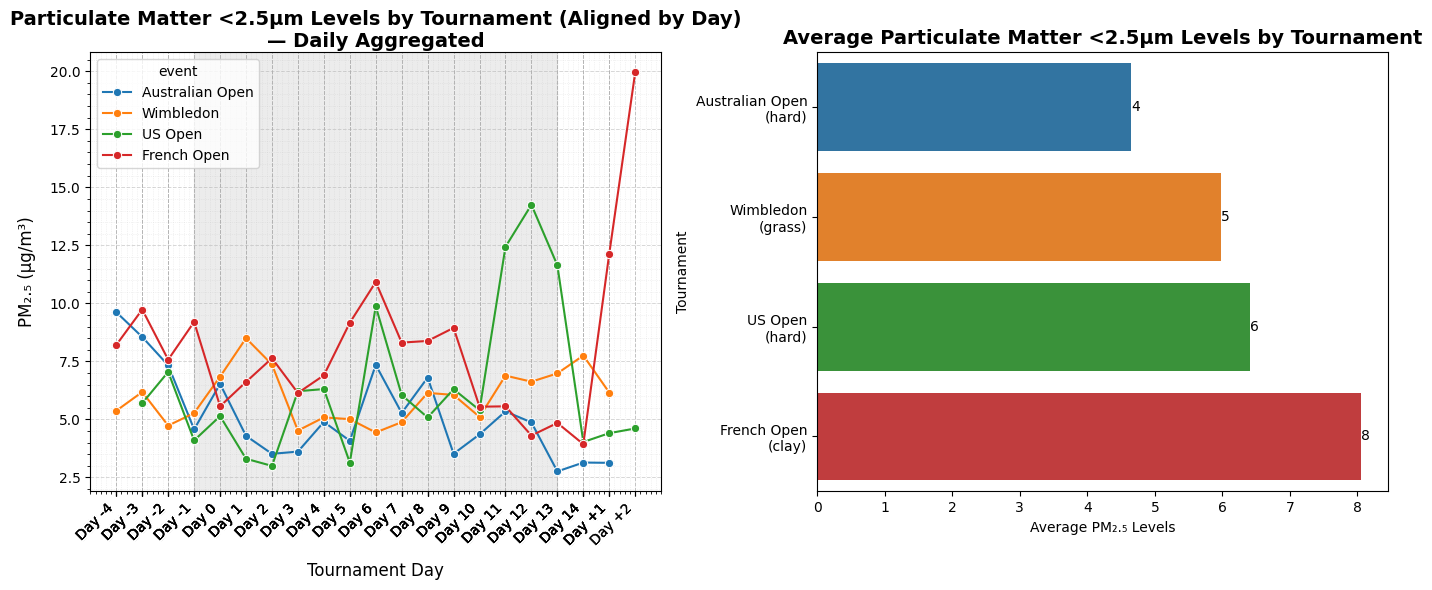

In [15]:
# Create composite plots for PM₂.₅
# First subplot Line Chart
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
ax1 = sns.lineplot(
    data=pm25_daily_average,
    x="day_relative",
    y="value",
    hue="event",
    hue_order=hue_order,
    marker="o"
)

# Add titles, labels, and grid
ax1.minorticks_on()
ax1.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.5)
ax1.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.3)
ax1.set_xlabel("Tournament Day", fontsize=12, labelpad=10)
ax1.set_ylabel("PM₂.₅ (µg/m³)", fontsize=12, labelpad=10)
ax1.set_title("Particulate Matter <2.5µm Levels by Tournament (Aligned by Day) — Daily Aggregated", fontsize=14, weight="bold", wrap=True)

# Shade the tournament window
ax1.axvspan(-1, 13, color="gray", alpha=0.15, label="Tournament Window")

# Force integer ticks on x-axis
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xticks(pm25_daily_average["day_relative"])
ax1.set_xticklabels(pm25_daily_average["day_label"], rotation=45, ha="right")

# Second subplot Bar Chart
# Create a mapping: "Australian Open" → "Australian Open\n(hard)"
event_labels = {
    arena["event"]: f"{arena['event']}\n({arena['court_type']})"
    for arena in tennis_arenas
}

pm25_window_average = pm25_window_average.copy()
pm25_window_average.loc[:, "event_label"] = pm25_window_average["event"].map(event_labels)

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=pm25_window_average,
                x="value",
                y="event_label",
                hue="event",
                hue_order=hue_order,
                legend=False)

# Add counts on top of each bar
for p in ax2.patches:
    width = p.get_width()
    ax2.annotate(f'{int(width)}',
                (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10)

# Add titles and labels
plt.xlabel("Average PM₂.₅ Levels")
plt.ylabel("Tournament")
plt.title("Average Particulate Matter <2.5µm Levels by Tournament",fontsize=14, weight="bold")

# Adjust layout so they don’t overlap
plt.rcParams["font.family"] = "DejaVu Sans"
plt.tight_layout()
plt.show()